Verificamos la estructura:
   game_id  club_id  own_goals  own_position      own_manager_name  \
0  3194823      148          3           6.0   Mauricio Pochettino   
1  3219136      762          1          13.0           Steve Bruce   
2  3219162      985          1           3.0  Ole Gunnar Solskjaer   
3  3219186      631          2           4.0         Frank Lampard   
4  3219187      543          0           8.0   Nuno Espírito Santo   

   opponent_id  opponent_goals  opponent_position opponent_manager_name  \
0          405               1               15.0            Dean Smith   
1          148               3                7.0         José Mourinho   
2          379               1               15.0           David Moyes   
3          148               1                6.0         José Mourinho   
4         1003               0                3.0       Brendan Rodgers   

  hosting  ...                    stadium attendance         referee  \
0    Home  ...  Tottenham Hot

C:\Users\ivizq\AppData\Local\Temp\ipykernel_14288\2796991190.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_without_duplicatedGames['result_num'] = merged_data['result'].map(result_mapping)
C:\Users\ivizq\AppData\Local\Temp\ipykernel_14288\2796991190.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='result', y='foreigners_number', data=merged_data, palette='coolwarm', inner="quartile")


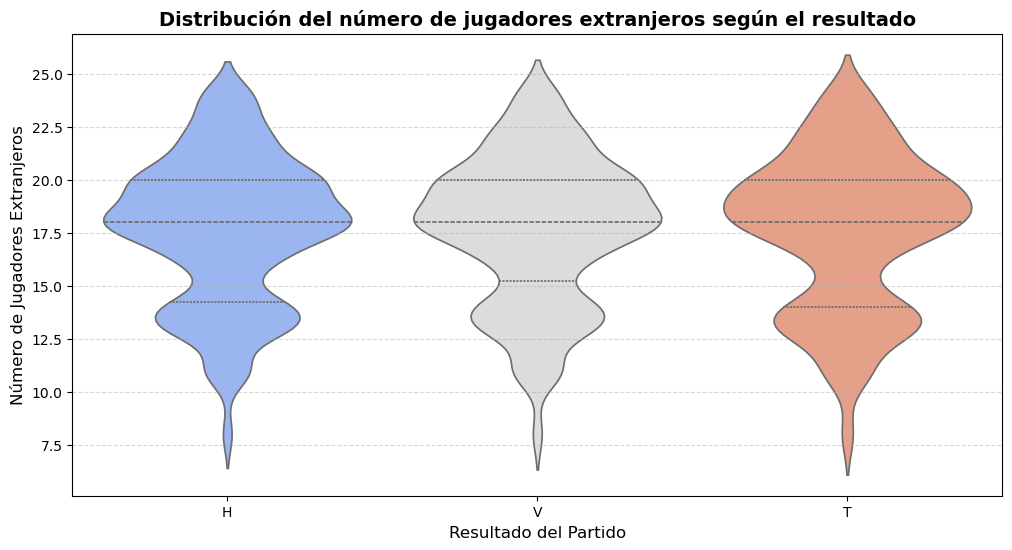

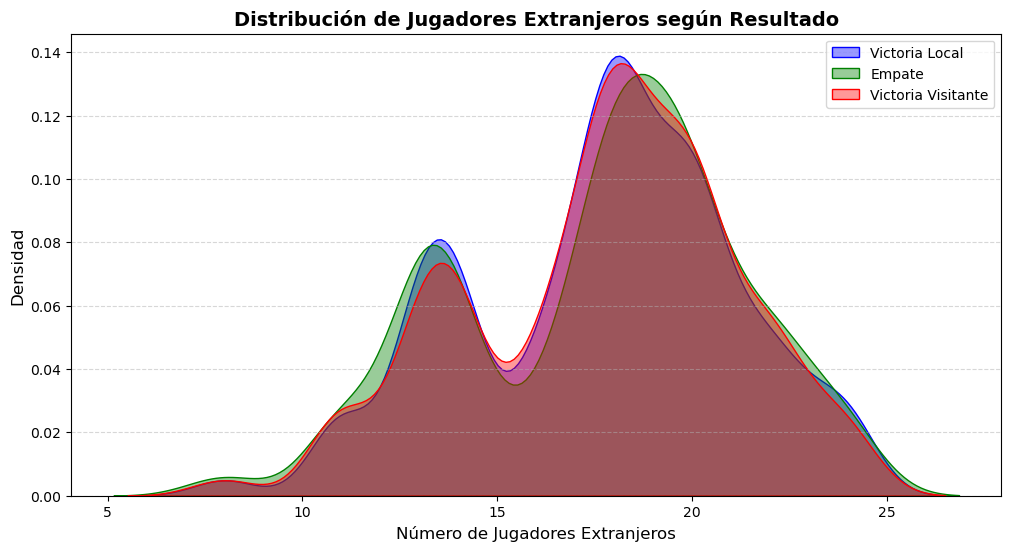

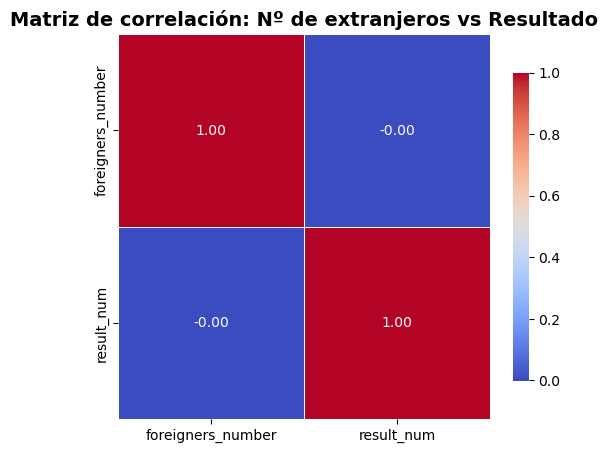

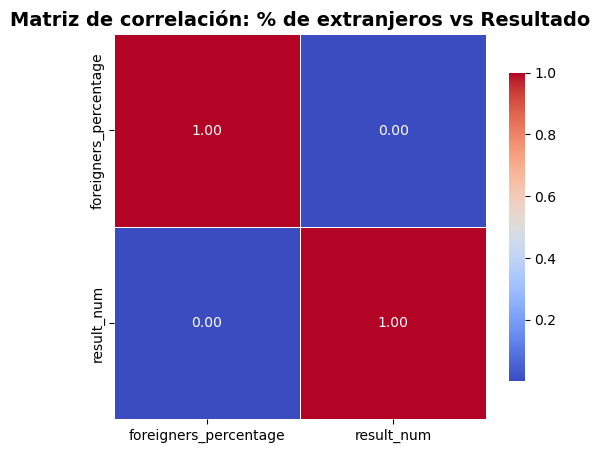

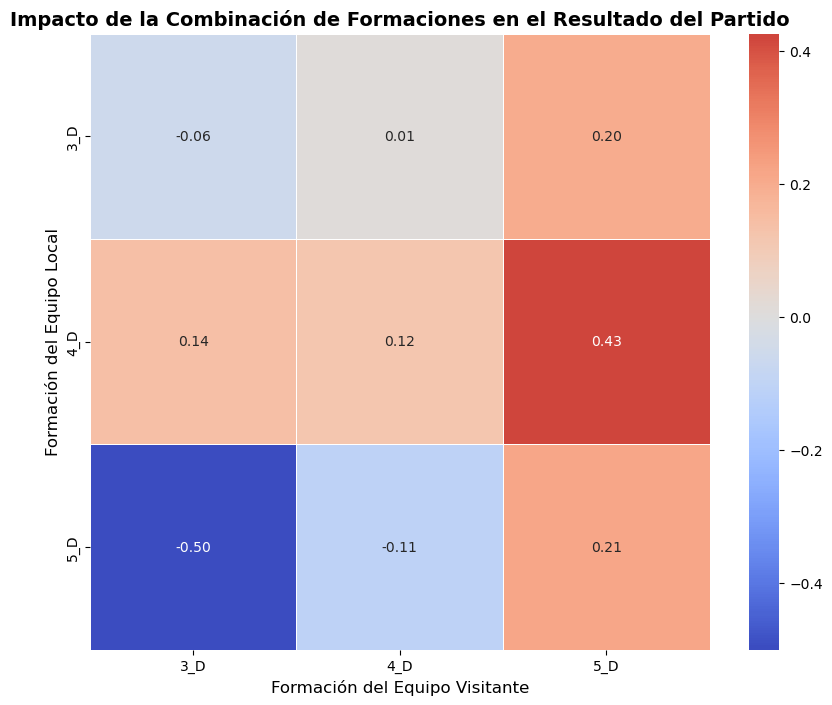

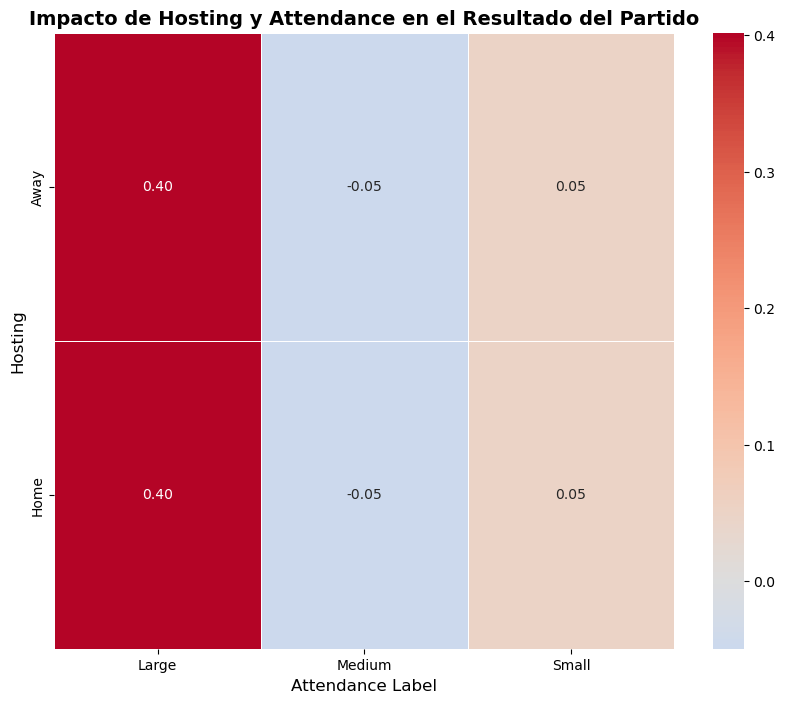

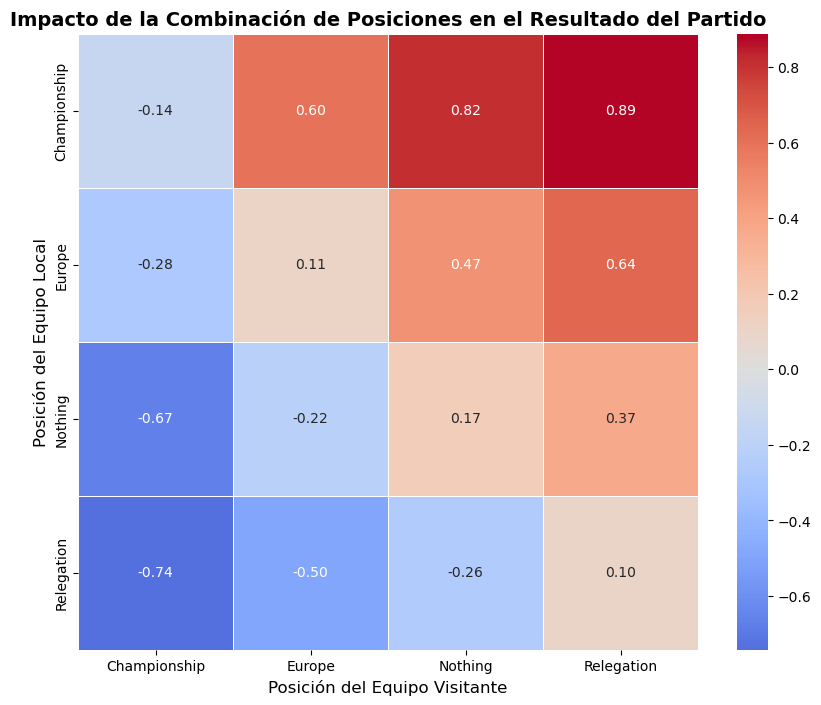

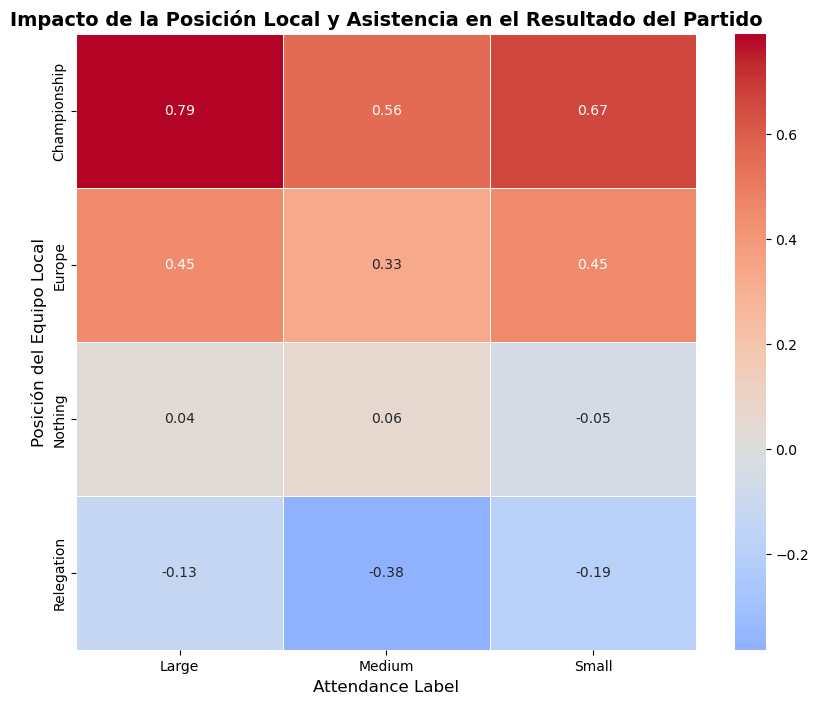

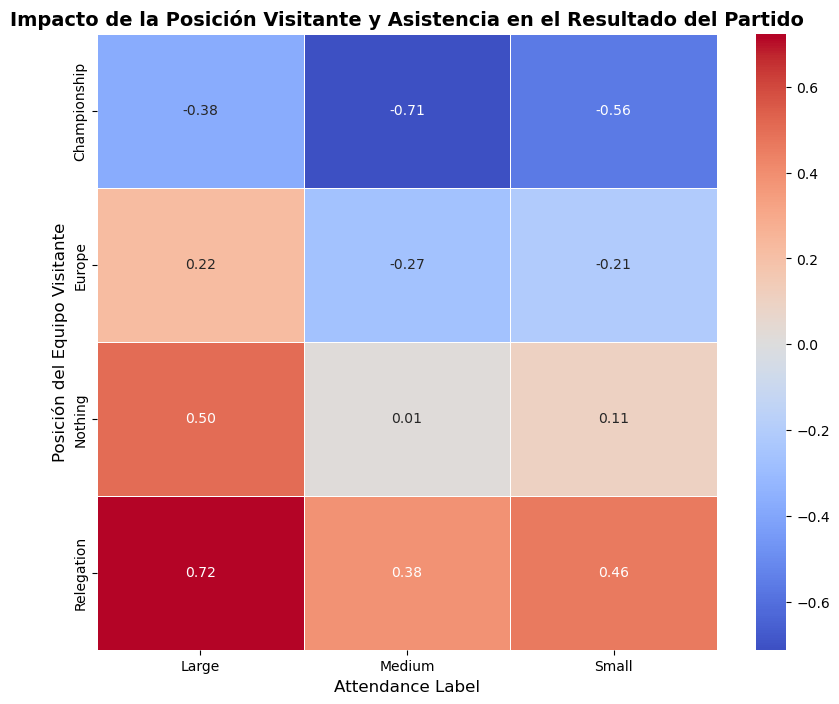

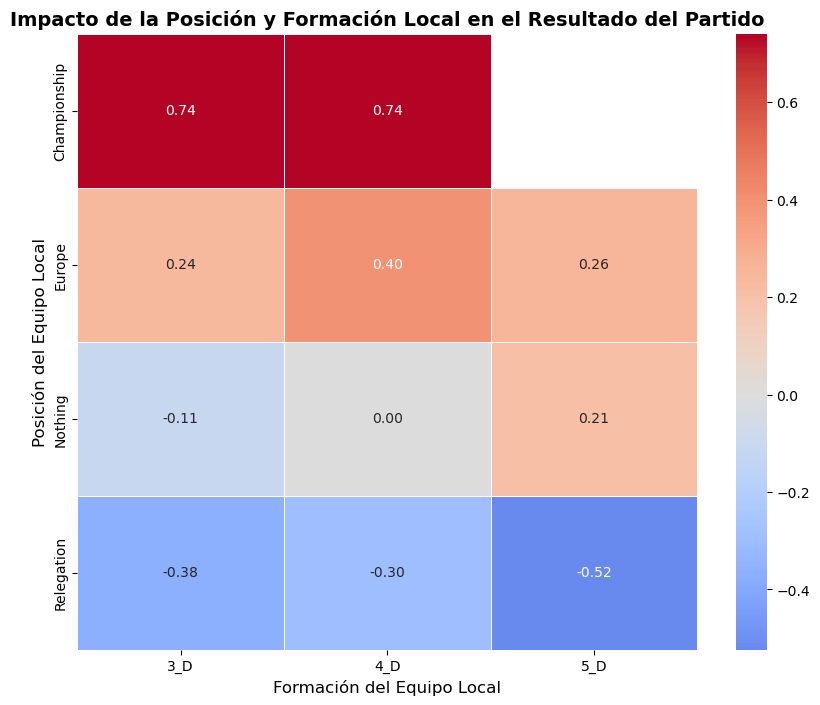

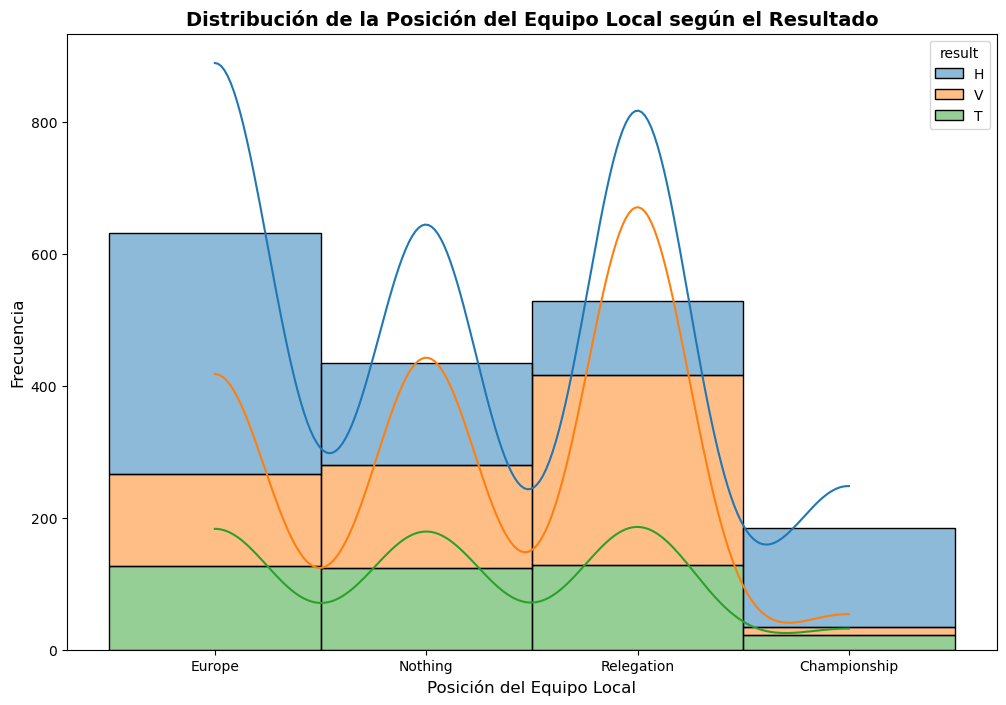

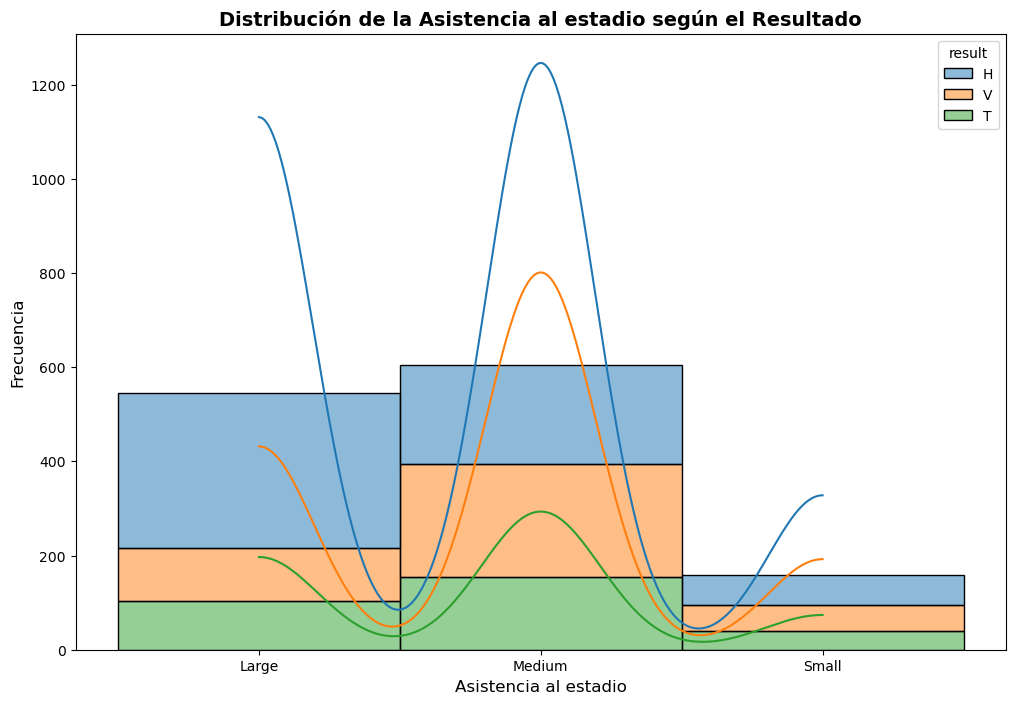

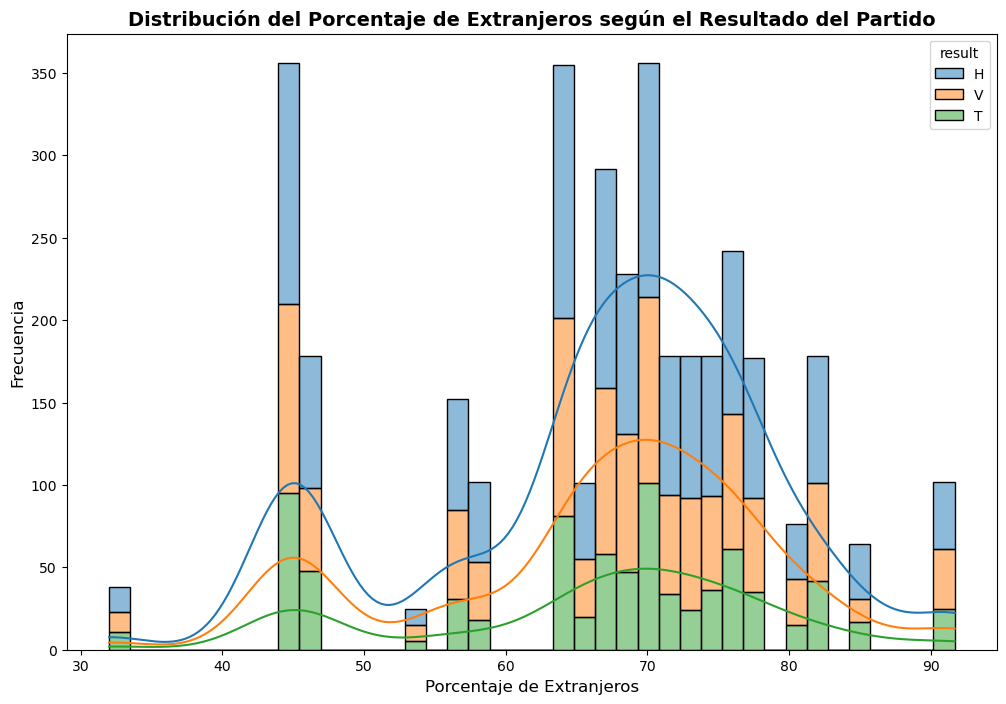

Text(0, 0.5, 'Frecuencia')

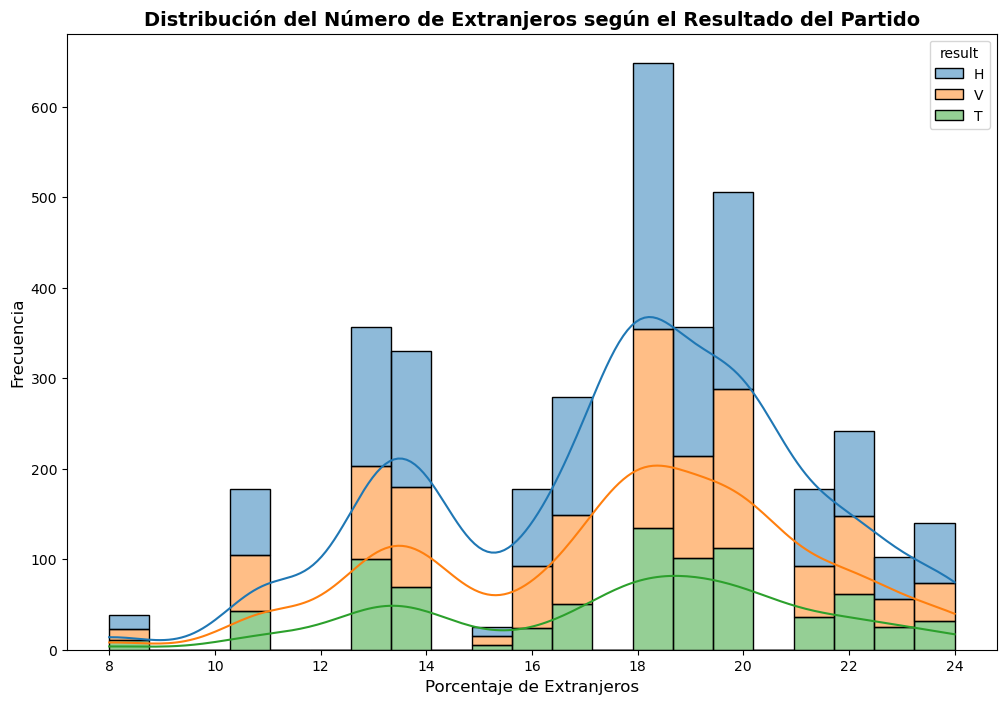

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic



def assign_attendance_label(attendance):
    if attendance > 40000:  
        return 'Large'
    elif 20000 <= attendance <= 40000: 
        return 'Medium'
    elif attendance < 20000:  
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if pd.isna(formation) or not isinstance(formation, str) or formation.strip() == "":
        return "Unknown"  
    if formation.startswith('4'):   
        return '4_D'
    elif formation.startswith('3'): 
        return '3_D'
    elif formation.startswith('5'): 
        return '5_D'
    else:
        return 'Other'


def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None




club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')

games_data = games_data[(games_data['season'] >= 2019) & 
                            (games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

club_data = club_data[club_data['domestic_competition_id'] == 'GB1'].copy()

games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)

# Paso 1: Unir club_games_data con club_data en base a club_id
merged_club_games = club_games_data.merge(club_data, on='club_id')

# Paso 2: Unir la tabla anterior con games_data en base a game_id
merged_data = merged_club_games.merge(games_data, on='game_id')

# Verificamos la estructura final
print("Verificamos la estructura:")
print(merged_data.head())

merged_data['result'] = merged_data.apply(lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                                                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

merged_data['home_club_position_label'] = merged_data['home_club_position'].apply(assign_position_label)
merged_data['away_club_position_label'] = merged_data['away_club_position'].apply(assign_position_label)
merged_data['home_club_formation_label'] = merged_data['home_club_formation'].apply(assign_formation_label)
merged_data['away_club_formation_label'] = merged_data['away_club_formation'].apply(assign_formation_label)
merged_data['attendance_label'] = merged_data['attendance'].apply(assign_attendance_label)


columns_to_keep = ['game_id', 'foreigners_number', 'foreigners_percentage', 'national_team_players' , 'average_age', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 'attendance_label',
                   'home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 'away_club_formation_label',
                   'home_club_goals', 'away_club_goals', 'hosting', 'is_win', 'result']

merged_data = merged_data[columns_to_keep]
merged_data_without_duplicatedGames = merged_data.drop_duplicates(subset='game_id' , keep='first')

# Verificamos la estructura final
print("Verificamos la estructura tras quedarnos con las columnas concretas:")
print(merged_data.head())

result_mapping = {'H': 1, 'T': 0, 'V': -1}
merged_data['result_num'] = merged_data['result'].map(result_mapping)
merged_data_without_duplicatedGames['result_num'] = merged_data['result'].map(result_mapping)

corr_foreigners_number = merged_data[['foreigners_number', 'result_num']].corr()
corr_foreigners_percentage = merged_data[['foreigners_percentage', 'result_num']].corr()


plt.figure(figsize=(12, 6))
sns.violinplot(x='result', y='foreigners_number', data=merged_data, palette='coolwarm', inner="quartile")
plt.title('Distribución del número de jugadores extranjeros según el resultado', fontsize=14, fontweight='bold')
plt.xlabel('Resultado del Partido', fontsize=12)
plt.ylabel('Número de Jugadores Extranjeros', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data[merged_data['result'] == 'H']['foreigners_number'], label="Victoria Local", fill=True, color="blue", alpha=0.4)
sns.kdeplot(merged_data[merged_data['result'] == 'T']['foreigners_number'], label="Empate", fill=True, color="green", alpha=0.4)
sns.kdeplot(merged_data[merged_data['result'] == 'V']['foreigners_number'], label="Victoria Visitante", fill=True, color="red", alpha=0.4)
plt.title('Distribución de Jugadores Extranjeros según Resultado', fontsize=14, fontweight='bold')
plt.xlabel('Número de Jugadores Extranjeros', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_foreigners_number, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Matriz de correlación: Nº de extranjeros vs Resultado", fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_foreigners_percentage, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Matriz de correlación: % de extranjeros vs Resultado", fontsize=14, fontweight='bold')
plt.show()


# 🔹 Creamos una tabla pivote para analizar la media del resultado según cada combinación de formaciones

formation_correlation = merged_data_without_duplicatedGames.pivot_table(index='home_club_formation_label', 
                                                columns='away_club_formation_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre formaciones del equipo local y visitante en relación con el resultado
plt.figure(figsize=(10, 8))
sns.heatmap(formation_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de la Combinación de Formaciones en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Formación del Equipo Visitante', fontsize=12)
plt.ylabel('Formación del Equipo Local', fontsize=12)
plt.show()


# 🔹 Creamos una tabla pivote para analizar la media del resultado según cada combinación de hosting y attendance_label

attendance_correlation = merged_data.pivot_table(index='hosting', 
                                                columns='attendance_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre hosting y attendance_label en relación con el resultado
plt.figure(figsize=(10, 8))
sns.heatmap(attendance_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de Hosting y Attendance en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Attendance Label', fontsize=12)
plt.ylabel('Hosting', fontsize=12)
plt.show()


# 🔹 Creamos una tabla pivote para analizar la media del resultado según cada combinación de posiciones del equipo local y visitante
position_correlation = merged_data_without_duplicatedGames.pivot_table(index='home_club_position_label', 
                                                columns='away_club_position_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre posiciones del equipo local y visitante en relación con el resultado
plt.figure(figsize=(10, 8))
sns.heatmap(position_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de la Combinación de Posiciones en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Posición del Equipo Visitante', fontsize=12)
plt.ylabel('Posición del Equipo Local', fontsize=12)


# 🔹 Creamos una tabla pivote para analizar la media del resultado según la posición local y el attendance_label
attendance_position_correlation = merged_data_without_duplicatedGames.pivot_table(index='home_club_position_label', 
                                                columns='attendance_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre posición local, attendance_label y resultado
plt.figure(figsize=(10, 8))
sns.heatmap(attendance_position_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de la Posición Local y Asistencia en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Attendance Label', fontsize=12)
plt.ylabel('Posición del Equipo Local', fontsize=12)
plt.show()

# 🔹 Creamos una tabla pivote para analizar la media del resultado según la posición local y el attendance_label
attendance_position_correlation = merged_data_without_duplicatedGames.pivot_table(index='away_club_position_label', 
                                                columns='attendance_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre posición local, attendance_label y resultado
plt.figure(figsize=(10, 8))
sns.heatmap(attendance_position_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de la Posición Visitante y Asistencia en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Attendance Label', fontsize=12)
plt.ylabel('Posición del Equipo Visitante', fontsize=12)
plt.show()


# 🔹 Creamos una tabla pivote para analizar la media del resultado según la posición local y la formación local
position_formation_correlation = merged_data_without_duplicatedGames.pivot_table(index='home_club_position_label', 
                                                columns='home_club_formation_label', 
                                                values='result_num', 
                                                aggfunc='mean')

# 🔥 Heatmap: Correlación entre posición local, formación local y resultado
plt.figure(figsize=(10, 8))
sns.heatmap(position_formation_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title('Impacto de la Posición y Formación Local en el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Formación del Equipo Local', fontsize=12)
plt.ylabel('Posición del Equipo Local', fontsize=12)
plt.show()


plt.figure(figsize=(12, 8))

# 🔹 Utilizamos Seaborn para crear un histograma
sns.histplot(data=merged_data_without_duplicatedGames, x='home_club_position_label', hue='result', multiple='stack', kde=True)

# 🔥 Añadimos título y etiquetas
plt.title('Distribución de la Posición del Equipo Local según el Resultado', fontsize=14, fontweight='bold')
plt.xlabel('Posición del Equipo Local', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# 🔹 Mostramos la gráfica
plt.show()


plt.figure(figsize=(12, 8))

# 🔹 Utilizamos Seaborn para crear un histograma
sns.histplot(data=merged_data_without_duplicatedGames, x='attendance_label', hue='result', multiple='stack', kde=True)

# 🔥 Añadimos título y etiquetas
plt.title('Distribución de la Asistencia al estadio según el Resultado', fontsize=14, fontweight='bold')
plt.xlabel('Asistencia al estadio', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# 🔹 Mostramos la gráfica
plt.show()

# 🔸 Creamos una figura y un conjunto de ejes
plt.figure(figsize=(12, 8))

# 🔹 Utilizamos Seaborn para crear un histograma
sns.histplot(data=merged_data, x='foreigners_percentage', hue='result', multiple='stack', kde=True)

# 🔥 Añadimos título y etiquetas
plt.title('Distribución del Porcentaje de Extranjeros según el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Extranjeros', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# 🔹 Mostramos la gráfica
plt.show()

# 🔸 Creamos una figura y un conjunto de ejes
plt.figure(figsize=(12, 8))

# 🔹 Utilizamos Seaborn para crear un histograma
sns.histplot(data=merged_data, x='foreigners_number', hue='result', multiple='stack', kde=True)

# 🔥 Añadimos título y etiquetas
plt.title('Distribución del Número de Extranjeros según el Resultado del Partido', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Extranjeros', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)



# print("Información básica de club_data:")
# print(club_data.info())
# print("\nPrimeras filas de club_data:")
# print(club_data.head())

# print("\nInformación básica de club_games_data:")
# print(club_games_data.info())
# print("\nPrimeras filas de club_games_data:")
# print(club_games_data.head())

# print("\nInformación básica de games_data:")
# print(games_data.info())
# print("\nPrimeras filas de games_data:")
# print(games_data.head())

# print("\nValores nulos en club_data:")
# print(club_data.isnull().sum())

# print("\nValores nulos en club_games_data:")
# print(club_games_data.isnull().sum())

# print("\nValores nulos en games_data:")
# print(games_data.isnull().sum())

# print("\nValores únicos y frecuencias en club_data:")
# for column in club_data.columns:
#     print(f"{column} - Valores únicos:")
#     print(club_data[column].value_counts())
#     print("\n")

# print("\nValores únicos y frecuencias en club_games_data:")
# for column in club_games_data.columns:
#     print(f"{column} - Valores únicos:")
#     print(club_games_data[column].value_counts())
#     print("\n")

# print("\nValores únicos y frecuencias en games_data:")
# for column in games_data.columns:
#     print(f"{column} - Valores únicos:")
#     print(games_data[column].value_counts())
#     print("\n")

# print("\nColumnas comunes entre club_data y club_games_data:")
# print(set(club_data.columns) & set(club_games_data.columns))

# print("\nColumnas comunes entre club_games_data y games_data:")
# print(set(club_games_data.columns) & set(games_data.columns))

# print("\nColumnas comunes entre club_data y games_data:")
# print(set(club_data.columns) & set(games_data.columns))


# print("\nEstadísticas descriptivas de club_data:")
# print(club_data.describe())

# print("\nEstadísticas descriptivas de club_games_data:")
# print(club_games_data.describe())

# print("\nEstadísticas descriptivas de games_data:")
# print(games_data.describe())

# print("\nGenerando histogramas para columnas numéricas...")

# columns_to_analyze_club_data = ['squad_size','average_age', 'foreigners_number','foreigners_percentage','national_team_players','stadium_seats']  
# columns_to_analyze_club_games_data = ['own_goals', 'own_position','opponent_goals','opponent_position']  
# columns_to_analyze_games_data = ['home_club_goals', 'away_club_goals','home_club_position','away_club_position','attendance','home_club_formation','away_club_formation']


# if set(columns_to_analyze_club_data).issubset(club_data.columns):
#     club_data[columns_to_analyze_club_data].hist(bins=20, figsize=(10, 10), color='blue', alpha=0.7)
#     plt.suptitle("Distribución de columnas numéricas seleccionadas - Club Data")
#     plt.show()
# else:
#     print("Algunas columnas seleccionadas no existen en club_data.")


# if set(columns_to_analyze_club_games_data).issubset(club_games_data.columns):
#     club_games_data[columns_to_analyze_club_games_data].hist(bins=20, figsize=(10, 10), color='green', alpha=0.7)
#     plt.suptitle("Distribución de columnas numéricas seleccionadas - Club Games Data")
#     plt.show()
# else:
#     print("Algunas columnas seleccionadas no existen en club_games_data.")


# if set(columns_to_analyze_games_data).issubset(games_data.columns):
#     games_data[columns_to_analyze_games_data].hist(bins=20, figsize=(10, 10), color='orange', alpha=0.7)
#     plt.suptitle("Distribución de columnas numéricas seleccionadas - Games Data")
#     plt.show()
# else:
#     print("Algunas columnas seleccionadas no existen en games_data.")



# print("\nGenerando gráficos de distribución para columnas categóricas...")


# columns_to_analyze_club_data = ['squad_size','average_age', 'foreigners_number','foreigners_percentage','national_team_players','stadium_seats'] 
# columns_to_analyze_club_games_data = ['own_goals', 'own_position','opponent_goals','opponent_position']  
# columns_to_analyze_games_data = ['home_club_goals', 'away_club_goals','home_club_position','away_club_position','attendance','home_club_formation','away_club_formation'] 


# for column in columns_to_analyze_club_data:
#     if column in club_data.columns: 
#         plt.figure(figsize=(8, 6))
#         sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")
#         plt.title(f"Distribución de {column} - Club Data")
#         plt.show()
#     else:
#         print(f"Columna {column} no encontrada en club_data.")


# for column in columns_to_analyze_club_games_data:
#     if column in club_games_data.columns: 
#         plt.figure(figsize=(8, 6))
#         sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")
#         plt.title(f"Distribución de {column} - Club Games Data")
#         plt.show()
#     else:
#         print(f"Columna {column} no encontrada en club_games_data.")


# for column in columns_to_analyze_games_data:
#     if column in games_data.columns:  
#         plt.figure(figsize=(8, 6))
#         sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")
#         plt.title(f"Distribución de {column} - Games Data")
#         plt.show()
#     else:
#         print(f"Columna {column} no encontrada en games_data.")



